# Figures, Part 2

## Setup packages.

In [1]:
require(data.table)
require(magrittr)
require(rpart)
require(sensitivity)
require(SobolSequence)

require(ggplot2)
#require(ggExtra)

Loading required package: data.table
Loading required package: magrittr
Loading required package: rpart
Loading required package: sensitivity
Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr
Loading required package: SobolSequence
Loading required package: ggplot2


## Read files.

### Load input ranges.

In [2]:
z.ranges <- fread("input-ranges-si.tsv")
z.ranges %>% dim

[1] 32  9

### Read design.

In [3]:
z.design <- fread("design-si.tsv")
z.design %>% dim

[1] 2500   64

In [4]:
n <- dim(z.design)[1]
k <- dim(z.design)[2] / 2

### Read inputs.

In [5]:
z.inputs <- fread("inputs-si.tsv")
z.inputs %>% dim

[1] 85000    33

### Read outputs.

In [6]:
z.outputs      <- fread("outputs-si-wide.tsv")
z.outputs.long <- fread("outputs-si-long.tsv")

### Read categories.

In [7]:
categories.input <- fread("categories-inputs.tsv")
categories.input[, unique(`Input Category`)]

[1] "Bioproduct Price"      "Commercial Technology" "Demo Technology"      
 [4] "Demoing"               "Feedstock Price"       "Government Incentives"
 [7] "Investor Behavior"     "Management Behavior"   "Market"               
[10] "Piloting"              "Randomization"         "Regulatory Approval"

In [8]:
categories.output <- fread("categories-outputs.tsv")
categories.output[, unique(`Output Category`)]

[1] "Business Metrics"      "Commercialization"     "Demoing"              
[4] "Government Incentives" "Investment Metrics"    "Market"               
[7] "Piloting"              "Regulatory Approval"

## Compute sensitivity indices

In [9]:
calc_st0 <- function(inp, out, ya, yb, ybia) {
    v <- sum(abs(ya - yb)^2)
    data.table(
        Input = inp,
        Output = out,
        S = (1 - sum(abs(ya - ybia)^2) / v),
        T = (    sum(abs(yb - ybia)^2) / v)
    )
}

calc_st <- function(inp, out, ya, yb, ybia, boot = 1) {
    if (boot == 1)
        return(calc_st0(inp, out, ya, yb, ybia))
    result <- NULL
    for (j in 1:boot) {
        ix <- sample(1:length(ya), length(ya), replace = TRUE)
        result <- rbind(
            result,
            calc_st0(inp, out, ya[ix], yb[ix], ybia[ix])
        )
    }
    result
}

In [10]:
sensitivityIndices <- function(inputs, outputs, boot = 1) {
    result <- NULL
    for (i in 5:ncol(outputs)) {
        ya <-        as.matrix(outputs[1:n              , i, with=FALSE])
        yb <-        as.matrix(outputs[1:n + n          , i, with=FALSE])
        yc <- matrix(as.matrix(outputs[(2*n+1):((k+2)*n), i, with=FALSE]), nrow=n, byrow=FALSE)
        for (j in 2:ncol(inputs)) {
            result <- rbind(
                result,
                calc_st(colnames(inputs)[j], colnames(outputs)[i], as.vector(ya), as.vector(yb), yc[, j-1], boot)
            )
        }
    }
    result
}

In [11]:
z.sens <- NULL
cases <- unique(z.outputs[, .(Replacement, Scale)])
for (i in 1:nrow(cases))
    z.sens <- rbind(
        z.sens,
        cbind(
            Replacement = cases[i, Replacement],
            Scale = cases[i, Scale],
            sensitivityIndices(z.inputs, z.outputs[Replacement == cases[i, Replacement] & Scale == cases[i, Scale] & Time == 2050])
        )
    )
z.sens %>% dim

[1] 6272    6

In [12]:
z.sens <- sensitivityIndices(
    z.inputs,
    z.outputs[Replacement == "Advantaged" & Scale == "Niche" & Time == 2050]
)

In [13]:
z.sens.category <- merge(
    merge(
        z.sens
    ,   categories.input
    ,   by = "Input"
    )
,   categories.output
,   by = "Output"
)[,
    .(
       `S max` = max(S, na.rm = TRUE)
    ,  `T max` = max(T, na.rm = TRUE)
    ) 
,   by = .(
    Input = `Input Category`
,   Output = `Output Category`
)
]

## First order sensitivity.

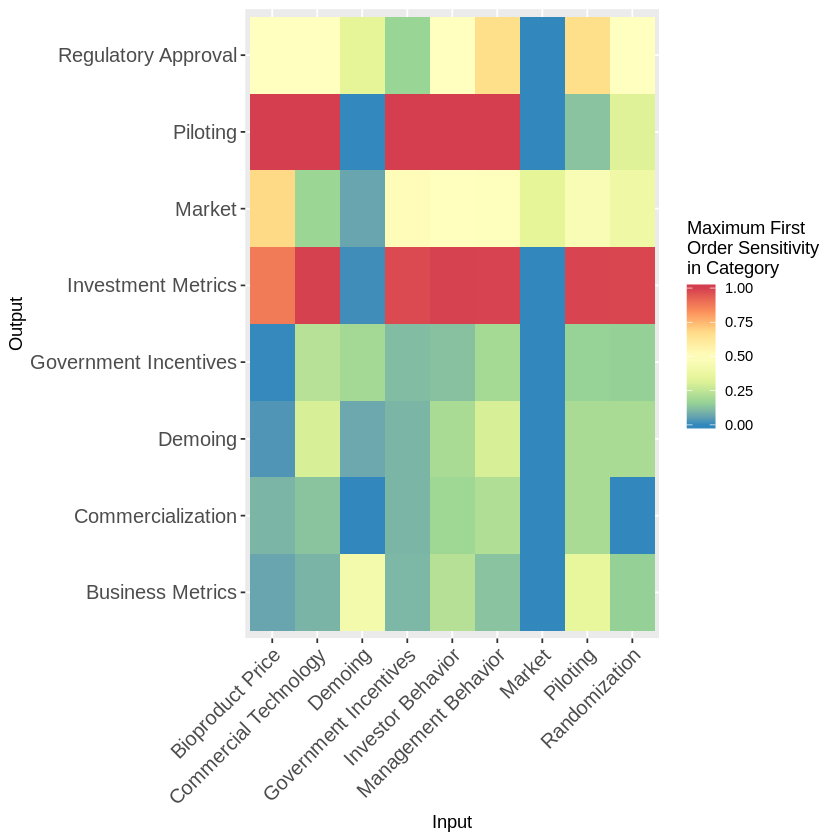

In [14]:
ggplot(
    z.sens.category[!is.nan(`S max`),
        .(Input, Output, `Maximum First\nOrder Sensitivity\nin Category`=mapply(function(x) max(0, min(1, x)), `S max`))
    ],
    aes(x=Input, y=Output, fill=`Maximum First\nOrder Sensitivity\nin Category`)
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size = 12),
        axis.text.x = element_text(angle = 45, hjust=1)
    )
ggsave("s-category.png", width = 6.5, height = 4.0, units = "in")

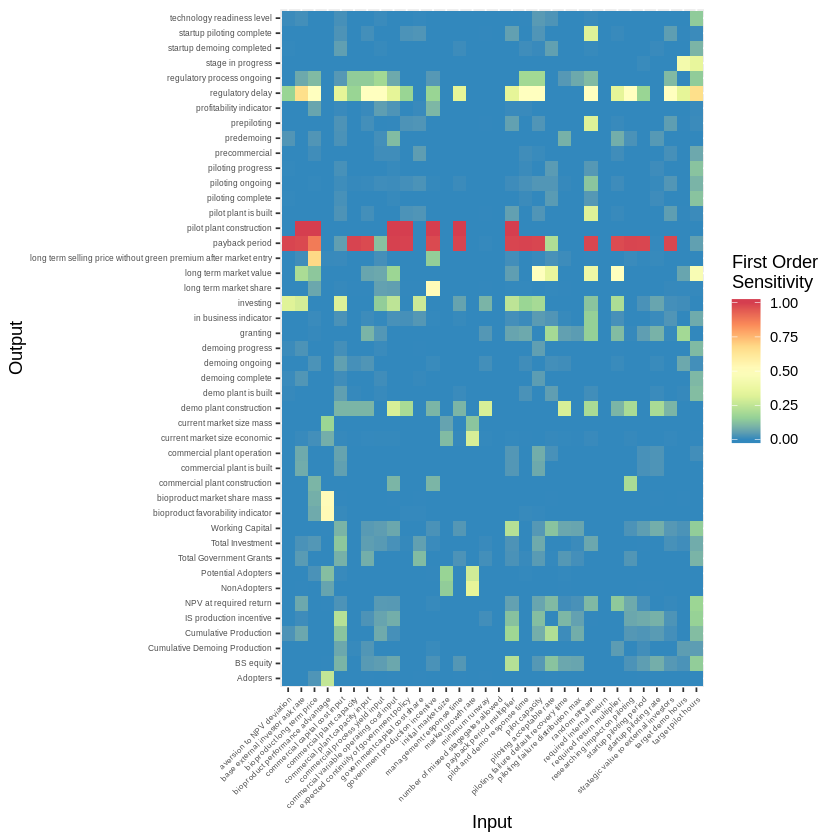

In [15]:
ggplot(
    z.sens[!is.nan(S),
        .(Input, Output, `First Order\nSensitivity`=mapply(function(x) max(0, min(1, x)), S))
    ],
    aes(x=Input, y=Output, fill=`First Order\nSensitivity`)
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size=5),
        axis.text.x = element_text(angle = 45, hjust=1)
    )
ggsave("s-variable.png", width = 6.5, height = 4.0, units = "in")

## Total sensitivity.

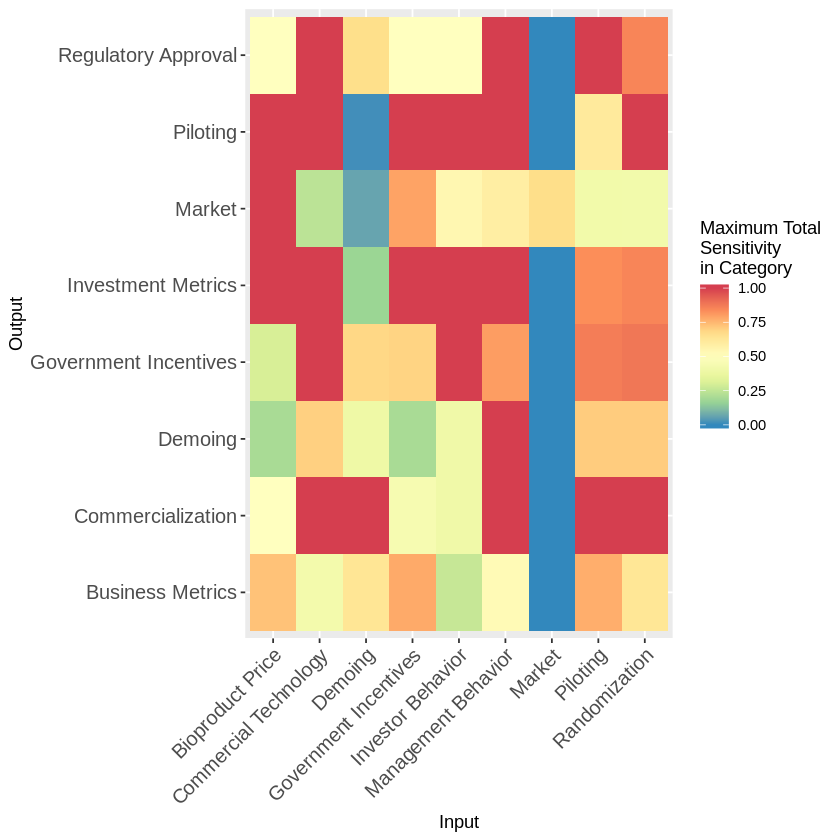

In [16]:
ggplot(
    z.sens.category[!is.na(`T max`),
        .(Input, Output, `Maximum Total\nSensitivity\nin Category`=mapply(function(x) max(0, min(1, x)), `T max`))
    ],
    aes(x=Input, y=Output, fill=`Maximum Total\nSensitivity\nin Category`)
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size = 12),
        axis.text.x = element_text(angle = 45, hjust=1)
    )
ggsave("t-category.png", width = 6.5, height = 4.0, units = "in")

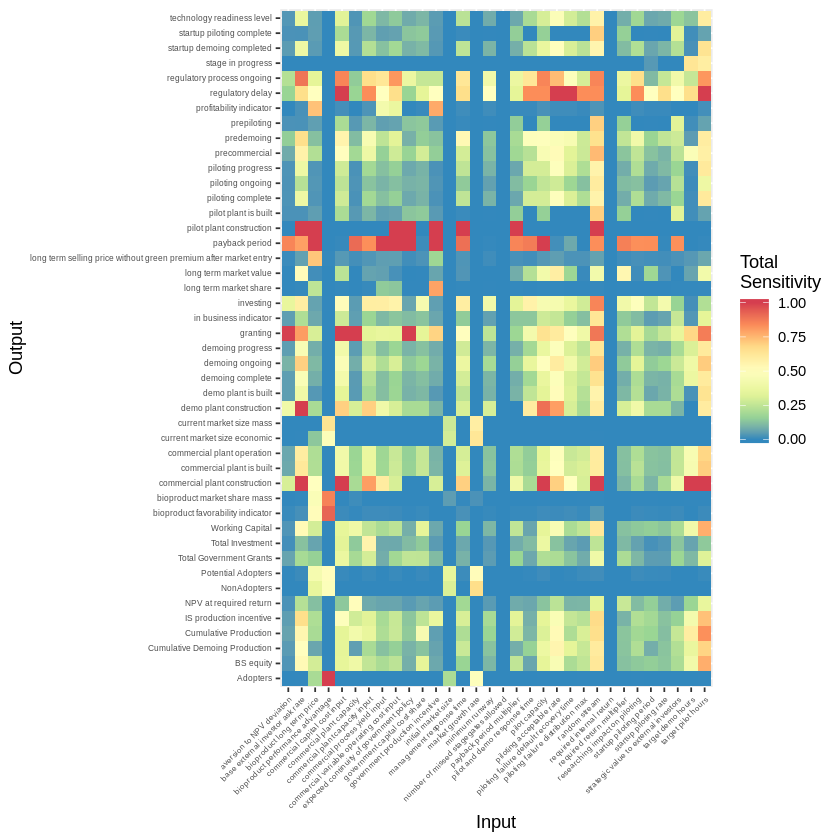

In [17]:
ggplot(
    z.sens[!is.na(T),
        .(Input, Output, `Total\nSensitivity`=mapply(function(x) max(0, min(1, x)), T))
    ],
    aes(x=Input, y=Output, fill=`Total\nSensitivity`)
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size = 5),
        axis.text.x = element_text(angle = 45, hjust=1)
    )
ggsave("t-variable.png", width = 6.5, height = 4.5, units = "in")

## Bootstrapped sensitivities.

In [18]:
z.sens.boot <- sensitivityIndices(
    z.inputs,
    z.outputs[
        Replacement == "Advantaged" & Scale == "Niche" & Time == 2050
    ],
    300
)
z.sens.boot %>% dim

[1] 470400      4

In [19]:
z.sens.boot.summary <- z.sens.boot[, .(
    `S mean` = mean(S, na.rm=TRUE),
    `S s.d.` = sd  (S, na.rm=TRUE),
    `T mean` = mean(T, na.rm=TRUE),
    `T s.d.` = sd  (T, na.rm=TRUE)
), by=.(Input, Output)][
    , .(
    Input,
    Output,
    `S mean`,
    `S s.d.`,
    `S ratio` = abs(`S mean`) / `S s.d.`,
    `T mean`,
    `T s.d.`,
    `T ratio` = abs(`T mean`) / `T s.d.`
)]

## Bootstrapped first order sensitivity.

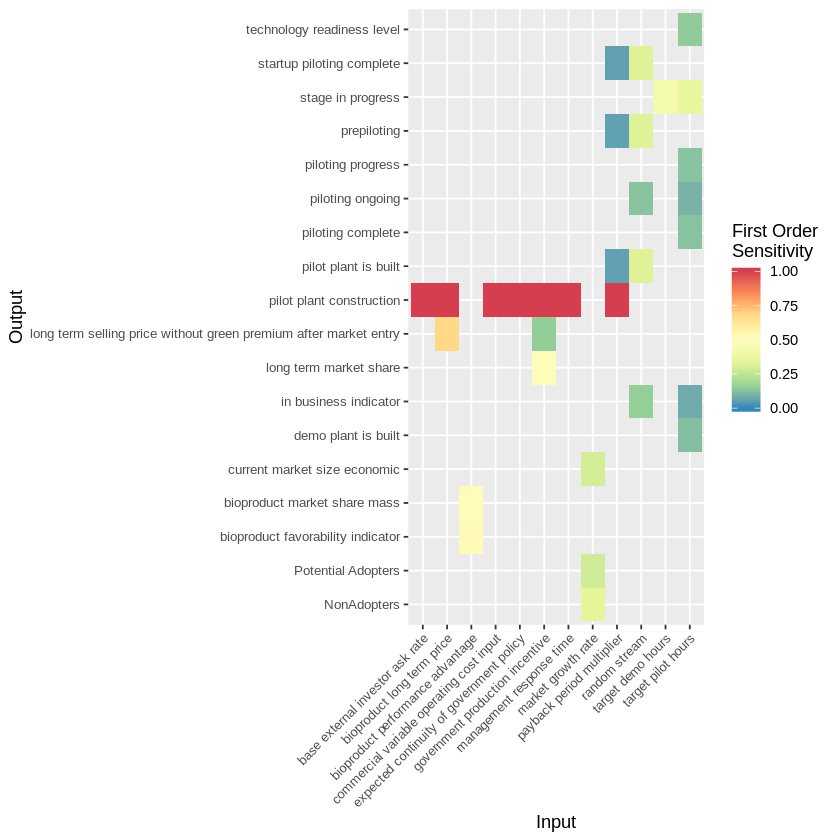

In [20]:
ggplot(
    z.sens.boot.summary[
        `S ratio` >= 4,
        .(Input, Output, `First Order\nSensitivity`=mapply(function(x) max(0, min(1, x)), `S mean`))
    ],
    aes(x=Input, y=Output, fill=`First Order\nSensitivity`)
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size = 8),
        axis.text.x = element_text(angle = 45, hjust=1)
    )
ggsave("s-bootstrap.png", width = 6.5, height = 4.0, units = "in")

## Bootstrapped total sensitivity.

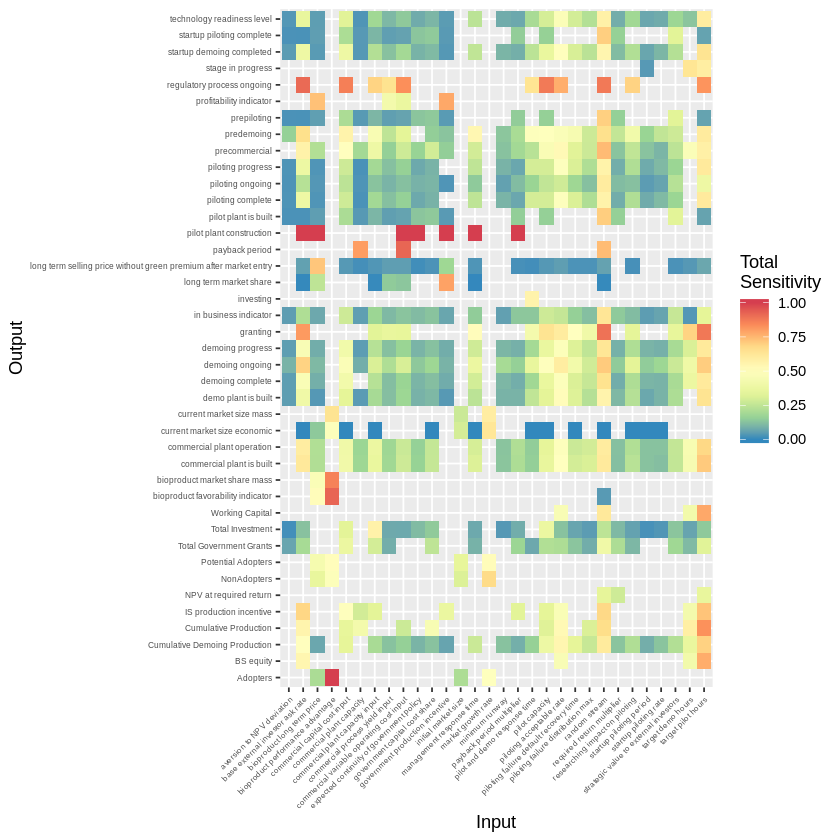

In [21]:
ggplot(
    z.sens.boot.summary[
        `T ratio` >= 4,
        .(Input, Output, `Total\nSensitivity`=mapply(function(x) max(0, min(1, x)), `T mean`))
    ],
    aes(x=Input, y=Output, fill=`Total\nSensitivity`)
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size = 5),
        axis.text.x = element_text(angle = 45, hjust=1)
    )
ggsave("t-bootstrap.png", width = 6.5, height = 4.5, units = "in")

In [22]:
z.sens.boot.summary[
        `T ratio` >= 4,
        .(Input, Output, `Total\nSensitivity`=mapply(function(x) max(0, min(1, x)), `T mean`))
][, .(`Maximum Total Sensitivity` = quantile(`Total\nSensitivity`, 0.9)), by = Input][
    order(- `Maximum Total Sensitivity`)
]

Input,Maximum Total Sensitivity
<chr>,<dbl>
bioproduct performance advantage,0.95345019
target pilot hours,0.78811884
government production incentive,0.78410637
random stream,0.74054002
base external investor ask rate,0.71684151
market growth rate,0.65632939
target demo hours,0.60194712
bioproduct long term price,0.59672904
piloting acceptable rate,0.58277502


## Random stream.

In [23]:
z.rstream <- fread("outputs-rn.tsv")
z.rstream[, .(`Cumulative Production` = median(`Cumulative Production`)), by = .(Replacement, Scale)]

Replacement,Scale,Cumulative Production
<chr>,<chr>,<dbl>
Advantaged,Commodity,19458.40
Advantaged,Niche,23393.05
Direct,Niche,23393.05
Direct,Commodity,19458.40


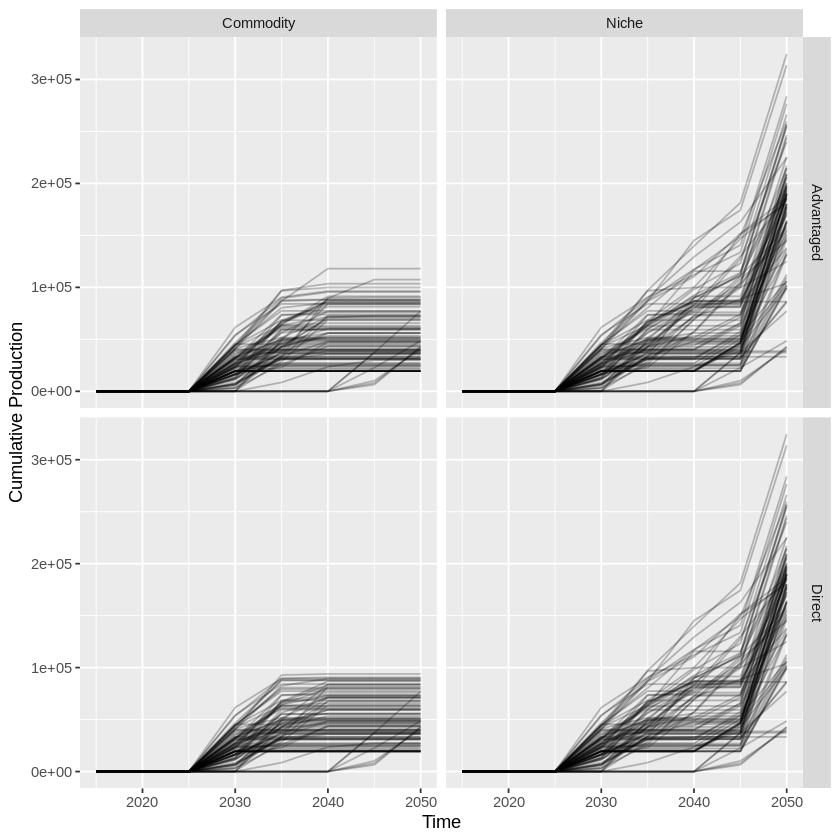

In [24]:
ggplot(
    z.rstream
,   aes(x = Time, y = `Cumulative Production`, group = `Run`)
) +
geom_line(alpha = 0.25) +
facet_grid(Replacement ~ Scale)
ggsave("rstream.png", width = 4.5, height = 4.5, units = "in")

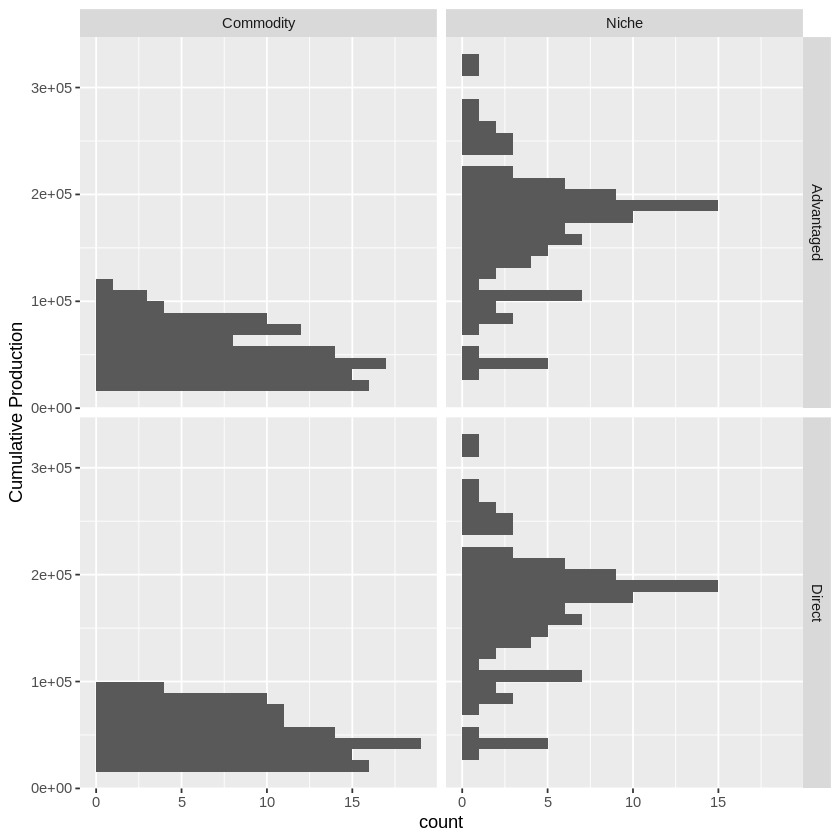

In [25]:
ggplot(
    z.rstream[Time == 2050]
,   aes(x = `Cumulative Production`)
) +
geom_histogram(bins = 30) +
coord_flip() +
facet_grid(Replacement ~ Scale)
ggsave("rstream-margins.png", width = 4.5, height = 4.5, units = "in")